In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
import torch.nn.functional as F

In [3]:
# Load images from folder, preprocess, and convert to grayscale
folder_path = "../Images"
images = []
for filename in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path, filename))
    img_gray_resized = cv2.resize(img, (256, 256))
    images.append(img_gray_resized/255.0)
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img_gray_resized = cv2.resize(img_gray, (256, 256))
    #images.append(img_gray_resized.reshape(256,256,1)/255.0)

# Convert images to PyTorch tensor
images_tensor = torch.tensor(images, dtype=torch.float32).permute(0,3,1,2) 



C:\Users\nmadali\AppData\Local\Temp\ipykernel_5520\3121384630.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  images_tensor = torch.tensor(images, dtype=torch.float32).permute(0,3,1,2)


In [4]:
os.listdir(folder_path)

['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg']

In [5]:
z_dim=2

In [6]:
class Autoencoder(nn.Module):
    def __init__(self,z_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (N, 1, 256, 256) -> (N, 16, 128, 128)
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (N, 16, 128, 128) -> (N, 32, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (N, 32, 64, 64) -> (N, 64, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # (N, 64, 32, 32) -> (N, 128, 16, 16)
            nn.ReLU(True),
        )
        # Latent space
        self.latent_space = nn.Linear(128 * 16 * 16, z_dim*2)
        # Decoder
        self.decoder_mlp= nn.Sequential(
            nn.Linear(z_dim, 128 * 16 * 16),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # (N, 128, 16, 16) -> (N, 64, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (N, 64, 32, 32) -> (N, 32, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (N, 32, 64, 64) -> (N, 16, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # (N, 16, 128, 128) -> (N, 1, 256, 256)
            nn.Sigmoid(),
            
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encoding(self,x):
        x = self.encoder(x)
        
        x = x.reshape(x.size(0), -1)  # flatten the tensor
        latent_params = self.latent_space(x)
        
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        return mu, logvar
    def decoding(self,x):
        x=self.decoder_mlp(x).view(x.size(0), 128, 16, 16)
        x = self.decoder(x)  # reshape the tensor
        return x
    def forward(self, x):
        x = self.encoder(x)
        
        x = x.reshape(x.size(0), -1)  # flatten the tensor
        latent_params = self.latent_space(x)
        
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        
        x=self.decoder_mlp(z).view(x.size(0), 128, 16, 16)
        x = self.decoder(x)  # reshape the tensor
        return x,mu, logvar


In [12]:
def loss_function(x_hat,x , mean, log_var):
    loss1 =nn.functional.binary_cross_entropy(x_hat[:,0],x[:,0], reduction='sum')
    loss2 =nn.functional.binary_cross_entropy(x_hat[:,1], x[:,1], reduction='sum')
    loss3 =nn.functional.binary_cross_entropy(x_hat[:,2], x[:,2], reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return loss1+loss2+loss3 + KLD


In [13]:
# Initialize model
model = Autoencoder(z_dim).cuda()

In [14]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
outputs,mu, logvar = model(images_tensor.float().cuda())

In [16]:
# Training
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    optimizer.zero_grad()
    outputs,mu, logvar = model(images_tensor.float().cuda())
    #print(torch.min(outputs).item(),torch.max(outputs).item())
    loss = loss_function(outputs, images_tensor.cuda(), mu, logvar) 
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    train_losses.append(running_loss)
    if epoch %100==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))



Epoch [1/1000], Loss: 529580.2500
Epoch [101/1000], Loss: 440519.3125
Epoch [201/1000], Loss: 419124.2188
Epoch [301/1000], Loss: 409458.6875
Epoch [401/1000], Loss: 401722.1562
Epoch [501/1000], Loss: 398536.6875
Epoch [601/1000], Loss: 396732.2500
Epoch [701/1000], Loss: 395968.1562
Epoch [801/1000], Loss: 395493.4688
Epoch [901/1000], Loss: 395109.0000


In [17]:
# Scatter plot of latent space
with torch.no_grad():
    mu, logvar = model.encoding(images_tensor.cuda())
    mu, logvar =mu.detach().cpu().numpy(), logvar.detach().cpu().numpy()


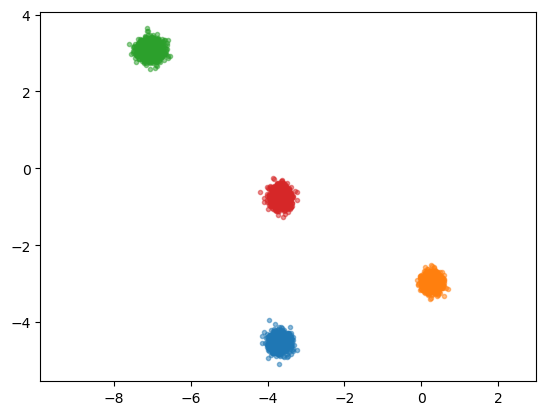

In [18]:
for i in range(len(mu)):
    cov=np.zeros((2,2))
    cov[0,0]=np.exp(0.5*logvar[i,0])
    cov[1,1]=np.exp(0.5*logvar[i,1])
    pts = np.random.multivariate_normal(mu[i], cov, size=1000)

    plt.plot(pts[:, 0], pts[:, 1], '.', alpha=0.5)
plt.axis('equal')
plt.show()

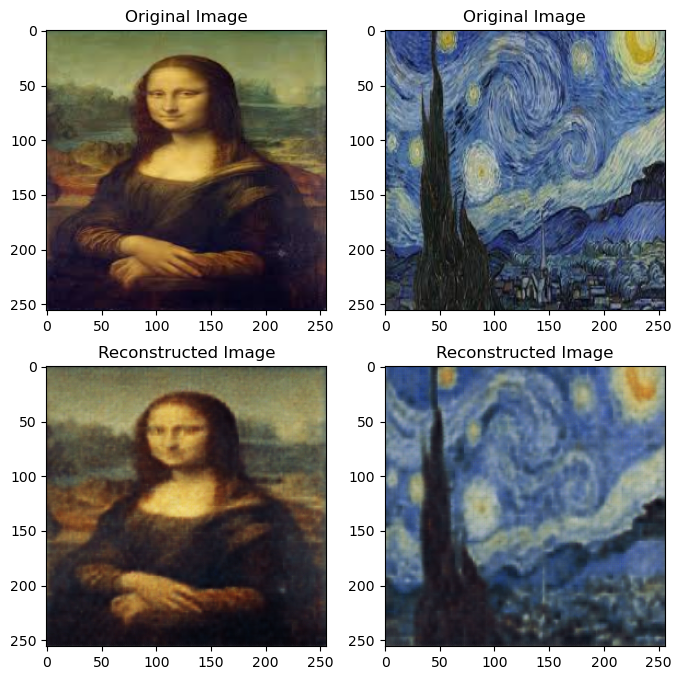

In [19]:
# Reconstruction of selected images
selected_images = images_tensor[:2]
with torch.no_grad():
    reconstructed_images,_,_ = model(selected_images.cuda())
    reconstructed_images=reconstructed_images.permute(0,2,3,1).detach().cpu().numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    axes[0, i].imshow(np.flip(selected_images.permute(0,2,3,1)[i].numpy(),-1))
    axes[0, i].set_title('Original Image')
    axes[1, i].imshow(np.flip(reconstructed_images[i],-1))
    axes[1, i].set_title('Reconstructed Image')
plt.show()

In [20]:
img_names=['Monalisa','Strarry Night','The Girl','Van Gogh']

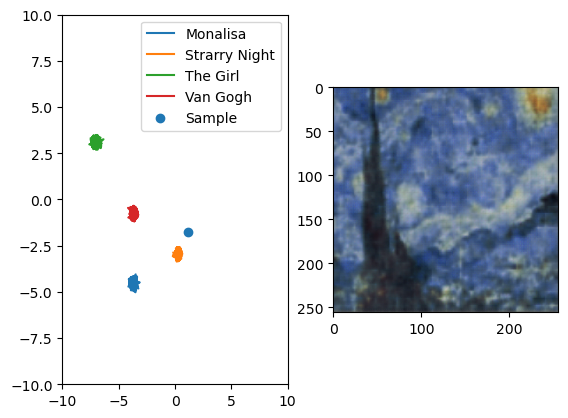

In [27]:
latent = torch.randn(1, z_dim).cuda()
with torch.no_grad():
    interpolated_images= model.decoding(latent).clip(0,1).permute(0,2,3,1).detach().cpu().numpy()
plt.subplot(121)
for i in range(len(mu)):
    cov=np.zeros((2,2))
    cov[0,0]=np.exp(0.5*logvar[i,0])
    cov[1,1]=np.exp(0.5*logvar[i,1])
    pts = np.random.multivariate_normal(mu[i], cov, size=1000)

    plt.plot(pts[:, 0], pts[:, 1], label=img_names[i])
plt.scatter(latent.detach().cpu().numpy()[0,0],latent.detach().cpu().numpy()[0,1],label='Sample')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.legend()
plt.subplot(122)
plt.imshow(np.flip(interpolated_images[0],-1))